In [161]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

# Motion Encoder

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, num_bones, traj_channels, traj_samples, hidden_size):
        super(Encoder, self).__init__()

        # 3D velocity + Dual quaternion channels of a bone
        self.v_channels = 3
        self.dq_channels = 8
        self.bone_channels = self.v_channels + self.dq_channels

        # Convolutional layers
        self.conv_v = nn.Conv1d(self.v_channels, 1, kernel_size=5, padding=2, padding_mode='zeros')
        self.conv_dq = nn.Conv1d(self.dq_channels, 2, kernel_size=5, padding=2, padding_mode='replicate')
        self.conv_traj = nn.Conv1d(traj_channels, 3, kernel_size=traj_samples)

        self.conv_out_channels = num_bones*(1+2) + 3
        

        
        self.fc = nn.Sequential(
            nn.Linear(self.conv_out_channels, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),

            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.LeakyReLU()
        )
        
        # Two heads for μ and σ
        self.fc_mu = nn.Linear(hidden_size//2, num_bones)
        self.fc_sigma = nn.Linear(hidden_size//2, num_bones)

        self.num_bones = num_bones
        self.traj_channels = traj_channels
        self.traj_samples = traj_samples

    def forward(self, x):
        # x is first joint velocities followed by dual quaternions followed by trajectorries
        v = x[:, :self.num_bones * self.v_channels].view(-1, self.v_channels, self.num_bones)
        dq = x[:, :self.num_bones * self.dq_channels].view(-1, self.dq_channels, self.num_bones)
        traj = x[:, self.num_bones * self.bone_channels:].view(-1, self.traj_channels, self.traj_samples)

        v = torch.flatten(self.conv_v(v), start_dim=1)
        dq = torch.flatten(self.conv_dq(dq), start_dim=1)
        traj = torch.flatten(self.conv_traj(traj), start_dim=1)

        x = torch.cat((v, dq, traj), -1)

        x = self.fc(x)

        
        mu = self.fc_mu(x)
        sigma = torch.clamp(self.fc_sigma(x), min=-2, max=2)
        
        return mu, sigma


# Gating Network

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatingNetwork(nn.Module):
    def __init__(self, gating_features, gate_hidden_size, gate_dropout, num_experts):
        """
        gating_features is the length of the phase manifold per frame
        gate_hidden_size is the the size of the hidden layers for the gate
        gate_droput probability used in the gate
        num_experts is number of expert blending coefficients to be output
        """
        super(GatingNetwork, self).__init__()
 
        self.gate = nn.Sequential(

                    nn.Dropout(gate_dropout),
                    nn.Linear(gating_features, gate_hidden_size),
                    nn.BatchNorm1d(gate_hidden_size),
                    nn.ELU(),

                    nn.Dropout(gate_dropout),
                    nn.Linear(gate_hidden_size, gate_hidden_size),
                    nn.BatchNorm1d(gate_hidden_size),
                    nn.ELU(),

                    nn.Dropout(gate_dropout),
                    nn.Linear(gate_hidden_size, num_experts),
                    nn.Softmax(dim=-1),

        )

    def forward(self, x):

        # blending coefficients
        blend_weights = self.gate(x) # 

        return blend_weights

# Mixture of Experts Layer

In [164]:
import numpy as np

class MoE(nn.Module):
    def __init__(self, num_experts, expert_input_features, expert_output_features):
        super(MoE, self).__init__()
        
        # number of input features to the MoE layer
        self.expert_input_features = expert_input_features

        # number of output features of the MoE
        self.expert_output_features = expert_output_features

        self.num_experts = num_experts
        
        self.expert_weights = self.init_expert_weights([num_experts, expert_input_features, expert_output_features])
        self.expert_biases = self.init_expert_biases([num_experts, 1, expert_output_features])

    def init_expert_weights(self, shape):
        # Xavier Uniform weight initialization
        alpha_bound = np.sqrt(6.0 / np.prod(shape[-2:]))
        alpha = np.asarray(np.random.uniform(low=-alpha_bound, high=alpha_bound, size=shape), dtype=np.float32)
        return nn.Parameter(torch.from_numpy(alpha), requires_grad=True)

    def init_expert_biases(self, shape):
        return nn.Parameter(torch.zeros(shape, dtype=torch.float), requires_grad=True)

    def forward(self, x, blend_weights):
        y = torch.zeros((x.shape[0], self.expert_output_features), device=x.device, requires_grad=True)
        for i in range(self.num_experts):
            y = y + blend_weights[:,i].unsqueeze(1) * (x.matmul(self.expert_weights[i,:,:]) + self.expert_biases[i,:,:])
        return y

# Decoder

In [165]:
from utils.dual_quat import dqnorm

class Decoder(nn.Module):
    def __init__(self, gating_features, gate_hidden_size, gate_dropout, num_experts,
                 expert_input_features, expert_hidden,
                 num_bones, traj_dims, traj_samples):
        super(Decoder, self).__init__()

        self.gate = GatingNetwork(gating_features+num_bones, gate_hidden_size, gate_dropout, num_experts)

        ouput_fetures = num_bones*(3+8) + traj_dims * traj_samples

        self.expert_layer1 = MoE(num_experts, expert_input_features+num_bones, expert_hidden)
        self.expert_layer2 = MoE(num_experts, expert_hidden+num_bones, expert_hidden//2)
        self.expert_layer3 = MoE(num_experts, (expert_hidden//2)+num_bones, ouput_fetures)

        self.num_bones = num_bones
        self.traj_dims = traj_dims
        self.traj_samples = traj_samples


    def forward(self, pm, latent, pose):

        # latent variable and phase manifold is combined to be the input of the gate
        gate_ip = torch.cat((pm, latent), -1)
        blend_weights = self.gate(gate_ip)
        
        # First MoE layer with ELU activation
        y = torch.cat((latent,pose), -1)
        y = self.expert_layer1(y, blend_weights)
        y = F.elu(y)
        
        # Second MoE layer with ELU activation
        y = torch.cat((latent,y), -1)
        y = self.expert_layer2(y, blend_weights)
        y = F.elu(y)
        
        # Third MoE layer
        y = torch.cat((latent,y), -1)
        y = self.expert_layer3(y, blend_weights)

        # extract the unnormalized predicted dual quaternions for normalization
        dq_un_norm = y[:, -self.num_bones*8:]
        
        dq_un_norm = dq_un_norm.view(dq_un_norm.shape[0], dq_un_norm.shape[1]//8, -1)

        dq_norm = dqnorm(dq_un_norm)
        dq_norm = dq_norm.view(dq_norm.shape[0], -1)
        y = torch.cat((y[:, :-self.num_bones*8], dq_norm), -1)

        return y, dq_un_norm.view(dq_un_norm.shape[0], -1)



# Phase Predictor

In [166]:
class PhasePredictor(nn.Module):
    def __init__(self, input_features, phase_features, hidden_size):
        """
        phase_features is the length of the phase manifold to be output
        input_features is generally the length of the input pose at that frame
        hidden_size is the the size of the hidden layers for the gate
        """
        super(PhasePredictor, self).__init__()

 
        self.predictor = nn.Sequential(

                    nn.Linear(input_features, hidden_size),
                    nn.BatchNorm1d(hidden_size),
                    nn.Tanh(),

                    nn.Linear(hidden_size, hidden_size//2), 
                    nn.BatchNorm1d(hidden_size//2),   
                    nn.Tanh(),

                    nn.Linear(hidden_size//2, phase_features)
                    )
        
    def forward(self, velocities):
        pm = self.predictor(velocities)
           
        return pm

# MoVAE

In [167]:
class MoVAE(nn.Module):
    def __init__(self, num_bones, traj_dim, traj_samples, enc_hidden_size,
                 phase_features, phase_pred_hidden_size, 
                 gate_hidden_size, gate_dropout, num_experts, expert_hidden):
        super(MoVAE, self).__init__()

        self.encoder = Encoder(num_bones, traj_dim, traj_samples, enc_hidden_size)

        velocity_features = num_bones*(3)
        self.phase_pred = PhasePredictor(velocity_features, phase_features, phase_pred_hidden_size)

        pose_features = num_bones*(3+8)
        self.decoder = Decoder(phase_features, gate_hidden_size,
                               gate_dropout, num_experts, pose_features, 
                               expert_hidden,
                               num_bones, traj_dim, traj_samples)
        
        self.num_bones = num_bones
        self.traj_dim = traj_dim
        self.traj_samples = traj_samples


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, pm, pose, traj):
        # Combine previous pose and root trajectories as input for the encoder
        enc_input = torch.cat([pose, traj], dim=-1)
        
        # Encode to get μ and σ (log variance)
        mu, logvar = self.encoder(enc_input)
        
        # Sample latent z using the reparameterization trick
        z = self.reparameterize(mu, logvar)
        
        # Decode to get the traj and pose
        future, un_norm_dq = self.decoder(pm, z, pose)

        # Give future velocities to get the future phase manifold
        velocities = future[:, :-self.num_bones*8][:, -self.num_bones*3:]
    
        future_pm = self.phase_pred(velocities)

        future_traj = future[:, :self.traj_dim*self.traj_samples]

        # contains the future pose first num_bones*3 elements are the velocities and remaining are the dual quaternions
        future_pose = future[:, self.traj_dim*self.traj_samples:] 

        return future_pm, future_pose, future_traj, mu, logvar, un_norm_dq


test the network

In [168]:
num_bones = 26
traj_dim = 9
traj_samples = 13
enc_hidden_size = 128
phase_features = 10
phase_pred_hidden_size = 128
gate_hidden_size = 128
gate_dropout = 0.3
num_experts = 6
expert_hidden = 256

model = MoVAE(num_bones, traj_dim, traj_samples, enc_hidden_size,
              phase_features, phase_pred_hidden_size, 
              gate_hidden_size, gate_dropout, num_experts, expert_hidden)

batch_size = 64
pm_in = torch.rand(batch_size, phase_features)
pose_in = torch.rand(batch_size, num_bones*(3+8))
traj_in = torch.rand(batch_size, traj_dim*traj_samples)

print(pm_in.shape, pose_in.shape, traj_in.shape)

future_pm, future_pose, future_traj, mu, logvar, un_norm_dq = model(pm_in, pose_in, traj_in)

print(future_pm.shape, future_pose.shape, future_traj.shape, mu.shape, logvar.shape, un_norm_dq.shape)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

torch.Size([64, 10]) torch.Size([64, 286]) torch.Size([64, 117])
torch.Size([64, 10]) torch.Size([64, 286]) torch.Size([64, 117]) torch.Size([64, 26]) torch.Size([64, 26]) torch.Size([64, 208])
model size: 4.345MB


# Training and loss

In [178]:
import random

class ProbabilityFunction:
    def __init__(self, probability=0.5):
        self.probability = probability
        self.call_count = 0
        self.true_count = 0

    def set_probability(self, probability):
        """Set a new probability value."""
        self.probability = probability

    def reset(self):
        """Reset the call counter and true count."""
        self.call_count = 0
        self.true_count = 0

    def __call__(self):
        """Determine the result based on the current probability."""
        self.call_count += 1
        result = random.random() < self.probability
        if result:
            self.true_count += 1
        return result

    def get_statistics(self):
        """Return the statistics of true/false outcomes."""
        if self.call_count == 0:
            return {'true_count': 0, 'false_count': 0, 'probability': self.probability}
        return {
            'true_count': self.true_count,
            'false_count': self.call_count - self.true_count,
            'probability': self.probability
        }



In [179]:
import os
from utils.dual_quat import dqmul, dqinv, dq2mat, mat2dq, dqeye
import torch.nn.functional as F

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

class DQLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, dq1, dq2):
        """
        Compute a single dissimilarity score between two dual quaternions dq1 and dq2.
        The score is computed separately for the real and dual parts, then combined.
        Higher values indicate dissimilarity, and lower values close to 0 + epsilon indicate similarity.

        Args:
            dq1: Tensor of shape (..., 8) representing the first dual quaternion.
            dq2: Tensor of shape (..., 8) representing the second dual quaternion.
            epsilon: Small value to prevent zero similarity scores.

        Returns:
            mean_dissimilarity: A single scalar value representing the dissimilarity score.
        """
        # Split real and dual parts
        real1, dual1 = dq1[..., :4], dq1[..., 4:]
        real2, dual2 = dq2[..., :4], dq2[..., 4:]

        # Compute cosine similarity for real and dual parts
        real_similarity = F.cosine_similarity(real1, real2, dim=-1)
        dual_similarity = F.cosine_similarity(dual1, dual2, dim=-1)

        # Scale similarity from [-1, 1] to [0, 1]
        real_similarity = (real_similarity + 1) / 2
        dual_similarity = (dual_similarity + 1) / 2

        # Convert similarity to dissimilarity
        real_dissimilarity = 1 - real_similarity
        dual_dissimilarity = 1 - dual_similarity

        # Add epsilon to avoid zero dissimilarity
        real_dissimilarity = real_dissimilarity + self.eps
        dual_dissimilarity = dual_dissimilarity + self.eps

        # Sum the real and dual dissimilarities
        total_dissimilarity = real_dissimilarity + dual_dissimilarity

        # Compute the mean of the total dissimilarity across all dimensions
        mean_dissimilarity = total_dissimilarity.mean()

        return mean_dissimilarity

class MotionLoss(nn.Module):
    def __init__(self, parent_indices):
        """
        Initialize the MotionLoss module.

        Parameters:
            parent_indices (list or tensor): Indices defining the parent-child relationships 
                                            for the kinematic chain. Used for computing local 
                                            and global rotations in backward kinematics. 
                                            -1 for the root joint.

        Attributes:
            mse_loss (nn.Module): Mean Squared Error loss function for velocity and dual quaternion losses.
            parent_indices (list or tensor): Indices used for computing kinematic transformations.
        """
        super(MotionLoss, self).__init__()
        self.rmse_loss = RMSELoss()
        self.dq_loss = DQLoss()
        self.parent_indices = parent_indices

    def backward_kinematics(self, dq):
        '''
        Perform backward kinematics to calculate the local dual quaternion for the skeletal 
        heirerchy from the input global dual quaternion and parent dual quaternion.
        NOTE: Zeros out the Root Transform so that the root transform doesn't influence the joints

        Args:
            dq: Dual quaternions as tensor of shape (..., num_bones, 8), real part first.

        Returns:
            The local dual quaternion, a tensor of dual quaternions of shape (..., num_bones, 8).
        '''

        dq_copy = dq.clone() # to prevent in place operation error that autograd produces
        dq_copy[:, 0] = torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


        self.parent_indices[0] = 0
        parent_dq = dq_copy[:, self.parent_indices]

        local_dq = dqmul(dqinv(parent_dq), dq_copy)

        return local_dq
    
    def get_rot_pos(self, dq):
        """
        Calculate the rotation quaternion and the translation componenet from the dual quaternion.

        Args:
            dq: Dual quaternions as tensor of shape (..., 8), with real part first.

        Returns:
            The rotation quaternions and positions,  tensors of shape (..., 4), (..., 3) repectively.
        """

        rot = dq[..., :4]

        t = dq2mat(dq)
        pos = t[..., :3, 3]

        return rot, pos

    def dq_reg_loss(self, dq):
        """
        Calculate the dual quaternion regularization loss.

        This loss function enforces the unitary conditions for valid dual quaternions:
        1. The real part should have a norm of 1.
        2. The real and the dual parts should be orthogonal.

        Parameters:
            dq (torch.Tensor): A tensor containing dual quaternions with an arbitrary shape, 
                            but the last dimension must be of size 8. The first 4 components 
                            are for the real quaternion, and the remaining 4 are for the 
                            dual quaternion.

        Returns:
            torch.Tensor: The regularization loss for the dual quaternions.
        """
        real = dq[..., :4]
        dual = dq[..., 4:]

        real_norm = torch.sum(real ** 2, dim=-1)
        norm_penalty = (real_norm - 1) ** 2

        orthogonality_penalty = torch.sum(real * dual, dim=-1) ** 2

        loss = norm_penalty + orthogonality_penalty

        return loss

    def forward(self, output_pm, target_pm, output_traj, target_traj, output_v, target_v, output_dq, target_dq, unnorm_dq, mu, logvar):
        """
        Forward pass to calculate the total loss for motion data.

        This method calculates various loss components for supervised learning of motion data:
        1. RMSE Loss for velocities, global positions and offsets(to maintain bone lenghts)
        2. Dual Quaternion loss for local and root rel dual quaternions of the joints.
        3. Regularization loss for dual quaternions to ensure valid dual quaternions.
        4. KL Divergence loss to ensure normally distributed latent vector


        Parameters:
            output_pm (torch.Tensor): Predicted phase manifold  
            target_pm (torch.Tensor): Target phase manifold
            output_traj (torch.Tensor): Predicted trajectory
            target_traj (torch.Tensor): Target trajectory
            output_v (torch.Tensor): Predicted velocities of shape.
            target_v (torch.Tensor): Target velocities.
            output_dq (torch.Tensor): Predicted dual quaternions of shape (..., 8)
            target_dq (torch.Tensor): Target dual quaternions of shape (...., 8)
            unnorm_dq (torch.Tensor): Unnormalized dual quaternions for regularization loss of shape (..., 8)
            mu (torch.Tensor): mean of the latent vector of the encoder
            logvar (torch.Tensor): log variance of the latent vector of the encoder

        Returns:
            torch.Tensor: The total calculated loss.
        """

        # Basic MSE Loss for phase manifold, velocities and dual quaternions for supervised learning
        velocity_loss = self.rmse_loss(output_v, target_v)
        rootrel_dq_loss = self.dq_loss(output_dq, target_dq)
        phase_loss = self.rmse_loss(output_pm, target_pm)
        trajectory_loss = self.rmse_loss(output_traj, target_traj)

        # Getting local and global rotations, positions and offsets of the outputs
        output_local_dq = self.backward_kinematics(output_dq)
        output_local_q, output_offsets = self.get_rot_pos(output_local_dq)
        output_global_q, output_pos = self.get_rot_pos(output_dq)

        # Getting local and global rotations, positions and offsets of the ground truth
        target_local_dq = self.backward_kinematics(target_dq)
        target_local_q, target_offsets = self.get_rot_pos(target_local_dq)
        target_global_q, target_pos = self.get_rot_pos(target_dq)

        # Local dual quaternion loss
        loc_dq_loss = self.dq_loss(output_local_dq, target_local_dq)

        # Offset loss to ensure the bone lengths are maintained
        offset_loss = self.rmse_loss(output_offsets, target_offsets)

        # Global Position loss
        position_loss = self.rmse_loss(output_pos, target_pos)

        # Regularization loss for dual quaternions, helps learn valid dual quaternions
        dq_reg_loss = self.dq_reg_loss(unnorm_dq).mean()

        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        total_loss = phase_loss + trajectory_loss + velocity_loss + rootrel_dq_loss + loc_dq_loss + offset_loss + position_loss + dq_reg_loss + kld_loss
    
        print("-----------------------------------------")
        print(f"Velocity Loss: {velocity_loss.item():.6f}, Root Relative DQ Loss: {rootrel_dq_loss.item():.6f}, Local DQ Loss: {loc_dq_loss.item():.6f}")
        print(f"Offset Loss: {offset_loss.item():.6f}, Position Loss: {position_loss.item():.6f}, DQ regularization Loss: {dq_reg_loss.item():.6f}")
        print(f"Phase Loss: {phase_loss.item():.6f}, Trajectory Loss: {trajectory_loss.item():.6f}, KL Divergence Loss: {kld_loss.item():.6f}")
        print("-----------------------------------------")

        return total_loss
        

def train_model(model, dataloader, optimizer, scheduler, parent_indices, num_epochs=5, save_freq=2,
                device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                save_path="MoTran.pth", checkpoint_path=None):

    p = ProbabilityFunction()
    
    def get_teacher_forcing_pobability(epoch, cut_off, delay):
        delay = max(0, min(delay, 10))
        probability = 1 - (epoch/cut_off)**((delay*cut_off)/(epoch+1)) if epoch <= cut_off else 0
        return probability
    
    
    # Helps point out operatoion that isn't compatible with backprop
    torch.autograd.set_detect_anomaly(True)

    model.to(device)
    criterion = MotionLoss(parent_indices)
    start_epoch = 0

    num_bones = len(parent_indices)

    if checkpoint_path is not None:
        if os.path.exists(checkpoint_path):
            print("Loading checkpoint...")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        # Reset counters and set new probabilites
        p.reset()
        p.set_probability(get_teacher_forcing_pobability(epoch, num_epochs//2, 0.5))
        

        for data in dataloader:
            batch_size = data[0].shape[0]
            num_frames = data[0].shape[1]
            num_samples = data[5].shape[2] # Number of trajectory samples

            rvs, jvs, rdqs, jdqs, pms, trajs = [d.to(device) for d in data]

            pm_prev, pose_prev, traj_prev = None, None, None

            # Autoregressive training with teacher forcing
            loss = 0
            for i in range(num_frames-1):

                if i == 0 or p():
                    rv_ip, jv_ip, rdq_ip, jdq_ip, pm_ip, traj_ip = rvs[:,i], jvs[:,i], rdqs[:,i], jdqs[:,i], pms[:,i], trajs[:,i]          
                
                else:           
                    pm_ip = pm_prev
                    traj_ip = traj_prev.view(batch_size, num_samples, -1)
                    
                    # extract root and joints dual quaternions
                    rdq_ip = pose_prev[:, num_bones*3: num_bones*3 + 8]
                    jdq_ip = pose_prev[:, num_bones*3 + 8:].view(batch_size, num_bones-1, -1)

                    # extract root and joints velocities
                    rv_ip = pose_prev[:, :3]
                    jv_ip = pose_prev[:, 3: num_bones*3].view(batch_size, num_bones-1, -1)

                rv_des, jv_des, rdq_des, jdq_des, pm_des, traj_des = rvs[:,i+1], jvs[:,i+1], rdqs[:,i+1], jdqs[:,i+1], pms[:,i+1], trajs[:,i+1]
                rdq_des = dqmul(dqinv(rdqs[:,i]), rdq_des)
                rdq_ip = dqeye(*rdq_ip.shape[:1]).to(device)
                    
                
                # Flattening inputs and ground truth
                jv_flat = jv_ip.view(batch_size, -1)
                jdq_flat = jdq_ip.view(batch_size, -1)
                jv_ip = torch.cat((rv_ip, jv_flat), dim=-1)  
                jdq_ip = torch.cat((rdq_ip, jdq_flat), dim=-1)
                pose_ip = torch.cat((jv_ip, jdq_ip), -1)
                traj_ip = traj_ip.view(batch_size, -1)

                jv_flat = jv_des.view(batch_size, -1)
                jdq_flat = jdq_des.view(batch_size, -1)
                jv_des = torch.cat((rv_des, jv_flat), dim=-1)  
                jdq_des = torch.cat((rdq_des, jdq_flat), dim=-1)
                pose_des = torch.cat((jv_des, jdq_des), -1)
                traj_des = traj_des.view(batch_size, -1)

                
                pm_op, pose_op, traj_op, mu, logvar, un_norm_dq = model(pm_ip, pose_ip, traj_ip)
                
                # Store predictions to use as input in next frame
                pm_prev, pose_prev, traj_prev = pm_op, pose_op, traj_op

                jv_op = pose_op[:, :num_bones*3]
                jdq_op = pose_op[:, num_bones*3:].view(batch_size, num_bones, -1)
                un_norm_dq = un_norm_dq.view(batch_size, num_bones, -1)

                jdq_des = jdq_des.view(batch_size, num_bones, -1)
                # print(pm_out.shape, jv_out.shape, jdq_out.shape, jdq_norm.shape, traj_out.shape)
                # print(pm_des.shape, jv_des.shape, jdq_des.shape, traj_des.shape)

                loss += criterion(pm_op, pm_des, traj_op, traj_des, jv_op, jv_des, jdq_op, jdq_des, un_norm_dq, mu, logvar)


            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            scheduler.step()

            # add to the running loss
            running_loss += loss.item()
            print(p.get_statistics())
            print("Ran Backward Pass")
            
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.7f}')

        if (epoch+1) % save_freq == 0:

            # Save checkpoint after every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, save_path)
            print(f'Checkpoint saved at epoch {epoch}')
           
    print('Training complete')
    return model



In [282]:
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
from utils.motion_dataset import MotionDataset
import numpy as np

dataset = MotionDataset("../data/root_velocities.npy",
                      "../data/joint_velocities.npy",
                      "../data/root_transforms.npy",
                      "../data/joint_transforms.npy",
                      "../data/phase_manifolds.npy",
                      5, 13, 6, 6
)

num_bones = 26
traj_dim = 9
traj_samples = 13
enc_hidden_size = 128
enc_latent_dims = 26
phase_features = 10
phase_pred_hidden_size = 128
gate_hidden_size = 128
gate_dropout = 0.3
num_experts = 6
expert_hidden = 256

model = MoVAE(num_bones, traj_dim, traj_samples, enc_hidden_size,
              phase_features, phase_pred_hidden_size, 
              gate_hidden_size, gate_dropout, num_experts, expert_hidden)


parent_indices = np.load("../data/parent_indices.npy")

percentage = 1  # 100% of the data
num_samples = int(len(dataset) * percentage)

# Randomly sample indices for the subset
indices = np.random.choice(len(dataset), num_samples, replace=False)

# Create a subset dataset
subset = Subset(dataset, indices)


dataloader = DataLoader(subset, 256, True)


optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=2e-3, step_size_up=1000, mode='triangular2')


train_model(model, dataloader, optimizer, scheduler, parent_indices, num_epochs=100, save_freq=1, save_path="../models/MoVAE.pth", checkpoint_path="../models/MoVAE.pth")



Loading checkpoint...
Resuming training from epoch 52


C:\Users\mayur\AppData\Local\Temp\ipykernel_11956\134778146.py:247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


-----------------------------------------
Velocity Loss: 0.290076, Root Relative DQ Loss: 0.099814, Local DQ Loss: 0.130127
Offset Loss: 0.022093, Position Loss: 0.050363, DQ regularization Loss: 0.011633
Phase Loss: 0.236333, Trajectory Loss: 0.343451, KL Divergence Loss: 0.110630
-----------------------------------------
-----------------------------------------
Velocity Loss: 0.326716, Root Relative DQ Loss: 0.102613, Local DQ Loss: 0.129022
Offset Loss: 0.019279, Position Loss: 0.052114, DQ regularization Loss: 0.007604
Phase Loss: 0.266572, Trajectory Loss: 0.343783, KL Divergence Loss: 0.045801
-----------------------------------------
-----------------------------------------
Velocity Loss: 0.346794, Root Relative DQ Loss: 0.107427, Local DQ Loss: 0.138732
Offset Loss: 0.018310, Position Loss: 0.056942, DQ regularization Loss: 0.006963
Phase Loss: 0.286496, Trajectory Loss: 0.361453, KL Divergence Loss: 0.031822
-----------------------------------------
-------------------------

KeyboardInterrupt: 

C:\Users\mayur\AppData\Local\Temp\ipykernel_11956\2102215194.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../models/MoVAE.pth")


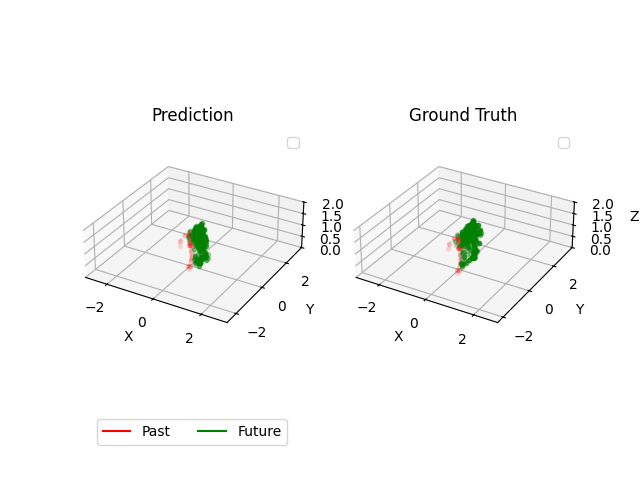

In [349]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from utils.plotter import plot_frame_sequence
%matplotlib widget


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("../models/MoVAE.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

item = np.random.randint(0, 256)

criterion = MotionLoss(parent_indices)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
ax1.set_title("Prediction")
ax2.set_title("Ground Truth")

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], color='red', linestyle='-', markersize=8, label='Past'),
    Line2D([0], [0], color='green', linestyle='-', markersize=8, label='Future')
]

# Add custom legend to the figure
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.3, 0.1), ncol=2)

pred_positions = None
true_positions = None

num_bones = 26

for data in dataloader:
    batch_size = data[0].shape[0]
    num_frames = data[0].shape[1]
    num_samples = data[5].shape[2] # Number of trajectory samples
    rvs, jvs, rdqs, jdqs, pms, trajs = [d.to(device) for d in data]

    # too keep track of the relative root dual quat and joint dual quats outputs at new frames
    rdq_rel_buffer = dqeye(batch_size, num_frames)
    jdq_buffer = dqeye(batch_size, num_frames, num_bones-1)

    # temporarily store the prveious outputs
    pm_prev, pose_prev, traj_prev = None, None, None
    # Autoregression
    loss = 0
    for i in range(num_frames-1):

        if i == 0:
            rv_ip, jv_ip, rdq_ip, jdq_ip, pm_ip, traj_ip = rvs[:,i], jvs[:,i], rdqs[:,i], jdqs[:,i], pms[:,i], trajs[:,i]
            jdq_buffer[:, 0] = jdq_ip
        else:           
            pm_ip = pm_prev
            traj_ip = traj_prev.view(batch_size, num_samples, -1)
            
            # extract root and joints dual quaternions
            rdq_rel_buffer[:, i] = rdq_ip = pose_prev[:, num_bones*3: num_bones*3 + 8]
            jdq_buffer[:, i] = jdq_ip = pose_prev[:, num_bones*3 + 8:].view(batch_size, num_bones-1, -1)

            # extract root and joints velocities
            rv_ip = pose_prev[:, :3]
            jv_ip = pose_prev[:, 3: num_bones*3].view(batch_size, num_bones-1, -1)


        rv_des, jv_des, rdq_des, jdq_des, pm_des, traj_des = rvs[:,i+1], jvs[:,i+1], rdqs[:,i+1], jdqs[:,i+1], pms[:,i+1], trajs[:,i+1]
        rdq_des = dqmul(dqinv(rdqs[:,i]), rdq_des)
        rdq_ip = dqeye(*rdq_ip.shape[:1]).to(device)
        
        
        # Flattening inputs and ground truth
        jv_flat = jv_ip.view(batch_size, -1)
        jdq_flat = jdq_ip.view(batch_size, -1)
        jv_ip = torch.cat((rv_ip, jv_flat), dim=-1)  
        jdq_ip = torch.cat((rdq_ip, jdq_flat), dim=-1)
        pose_ip = torch.cat((jv_ip, jdq_ip), -1)
        traj_ip = traj_ip.view(batch_size, -1)

        jv_flat = jv_des.view(batch_size, -1)
        jdq_flat = jdq_des.view(batch_size, -1)
        jv_des = torch.cat((rv_des, jv_flat), dim=-1)  
        jdq_des = torch.cat((rdq_des, jdq_flat), dim=-1)
        pose_des = torch.cat((jv_des, jdq_des), -1)
        traj_des = traj_des.view(batch_size, -1)

        
        pm_op, pose_op, traj_op, mu, logvar, un_norm_dq = model(pm_ip, pose_ip, traj_ip)

        # store predictions in buffer
        rdq_rel_buffer[:, i+1] = pose_op[:, num_bones*3: num_bones*3 + 8]
        jdq_buffer[:, i+1] = pose_op[:, num_bones*3 + 8:].view(batch_size, num_bones-1, -1)

        # Store predictions to use as input in next frame
        pm_prev, pose_prev, traj_prev = pm_op, pose_op, traj_op

        jv_op = pose_op[:, :num_bones*3]
        jdq_op = pose_op[:, num_bones*3:].view(batch_size, num_bones, -1)
        un_norm_dq = un_norm_dq.view(batch_size, num_bones, -1)

        jdq_des = jdq_des.view(batch_size, num_bones, -1)
        jdq_ip = jdq_ip.view(batch_size, num_bones, -1)
        # print(pm_out.shape, jv_out.shape, jdq_out.shape, jdq_norm.shape, traj_out.shape)
        # print(pm_des.shape, jv_des.shape, jdq_des.shape, traj_des.shape)

        # loss += criterion(pm_op, pm_des, traj_op, traj_des, jv_op, jv_des, jdq_op, jdq_des, un_norm_dq, mu, logvar)
    

    # Plotting the predictions
    rdq_rel = rdq_rel_buffer[item]
    jdq = jdq_buffer[item]
    jdq[0] = jdqs[item, 0]
    rdq = rdq_rel.clone()
    rdq[1:] = torch.stack([dqmul(rdq[i-1], rdq_rel[i]) for i in range(1, len(rdq))])
    jdq = torch.cat((rdq.unsqueeze(1), jdq), 1)
    mats = dq2mat(jdq).clone()
    mats_transformed = mats.clone()
    mats_transformed[:, 1:, :, :] = torch.matmul(mats[:, 0, :, :].unsqueeze(1), mats[:, 1:, :, :])
    pred_positions = mats_transformed[..., :3, 3].detach().cpu().numpy()
    plot_frame_sequence(ax1, pred_positions.copy(), parent_indices, 0)

    # plotting the ground truth
    rdq = rdqs[item]
    jdq = jdqs[item]
    rdq[1:] = dqmul(dqinv(rdq[0].unsqueeze(0)), rdq[1:])
    rdq[0] = dqeye()
    jdq = torch.cat((rdq.unsqueeze(1), jdq), 1)
    mats = dq2mat(jdq).clone()
    mats_transformed = mats.clone()
    mats_transformed[:, 1:, :, :] = torch.matmul(mats[:, 0, :, :].unsqueeze(1), mats[:, 1:, :, :])
    true_positions = mats_transformed[..., :3, 3].detach().cpu().numpy()
    plot_frame_sequence(ax2, true_positions.copy(), parent_indices, 0)

    break
    

In [351]:
from pythreejs import *
import numpy as np
from IPython.display import display, clear_output
import time

#  For choosing a random item from the batch
item = np.random.randint(0, 64)

# For generating checkers pattern
def gen_checkers(width, height, n_checkers_x, n_checkers_y):
    array = np.ones((width, height, 3), dtype='float32')

    # width in texels of each checker
    checker_w = width / n_checkers_x
    checker_h = height / n_checkers_y


    for y in range(height):
        for x in range(width):
            color_key = int(x / checker_w) + int(y / checker_h)
            if color_key % 2 == 0:
                array[x, y, :] = [ 0, 0, 0 ]
            else:
                array[x, y, :] = [ 1, 1, 1 ]
    # We need to flip x/y since threejs/webgl insists on column-major data for DataTexture
    return np.swapaxes(array, 0, 1)

print(pred_positions[-1, :4])

pred = pred_positions[:, :, [0, 2, 1]]
true = true_positions[:, :, [0, 2, 1]]
true[:, :, 0] += 1

frames = pred.shape[0]
print(frames)
# Create the scene
scene = Scene()

# Create a camera
camera = PerspectiveCamera(position=[4, 4, 3], lookAt=[0, 0, 0])

# Create a renderer
renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], width=600, height=600)

# Create a ground plane
data_tex = DataTexture(
    data=gen_checkers(20, 20, 20, 20),
    format="RGBFormat",
    type="FloatType",
)
plane_geometry = PlaneGeometry(width=20, height=20)
plane_material = MeshBasicMaterial(map=data_tex, color="green", side='DoubleSide')
plane = Mesh(geometry=plane_geometry, material=plane_material)
plane.rotateX(np.deg2rad(90))
scene.add(plane)

# Material for the line segments
m1 = LineMaterial(linewidth=3, color='cyan')
m2 = LineMaterial(linewidth=3, color='red')

# Initialize positions with zeros
pos = [[(0, 0, 0), (0, 0, 0)] for _ in range(len(parent_indices))]

# Create the geometry and line objects
g1 = LineSegmentsGeometry(positions=pos)
g2 = LineSegmentsGeometry(positions=pos)
pred_lines = LineSegments2(g1, m1)
true_lines = LineSegments2(g2, m2)
scene.add(pred_lines)
scene.add(true_lines
          
          )
def update_positions(frame):
    pred_pos = []
    true_pos = []
    for i, parent in enumerate(parent_indices):
        if parent != -1:
            pred_pos.append([pred[frame][parent], pred[frame][i]])
            true_pos.append([true[frame][parent], true[frame][i]])

    g1.positions = pred_pos
    g2.positions = true_pos
    g1.positionsNeedUpdate = True
    g2.positionsNeedUpdate = True

# Initialize with the first frame
update_positions(0)

display(renderer)

def animate(frame):
    update_positions(frame)
    renderer.render(scene, camera)

for frame in range(frames):
    animate(frame % frames)
    time.sleep(60/30.0)

[[ 0.19424614  0.41247177 -0.03080847]
 [ 0.1999312   0.46622622  0.8299506 ]
 [ 0.18574029  0.4335106   0.89967287]
 [ 0.19018455  0.43259162  0.98170245]]
6


Renderer(camera=PerspectiveCamera(position=(4.0, 4.0, 3.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.…